In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
signal_trees = ObjIter(list(map(Tree,fc.eightb.accstudies.raw_no_pu.signal_list)))
full_signal_trees = ObjIter(list(map(Tree,fc.eightb.accstudies.raw_no_pu.full_signal_list)))

# signal_trees.extend(kwargs=lambda tree : dict(n_ext_jet=tree.n_jet-tree.nfound_presel))
# signal_trees.extend(kwargs=eightb.reco_all)
# signal_trees.extend(kwargs=eightb.reco_res_all)

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


In [3]:
def get_point(label):
    label = label.split('_')
    return str((int(label[1]),int(label[3])))
signal_points = list(map(get_point,signal_trees.sample))

In [4]:
dout = "gen_studies/quarks/"

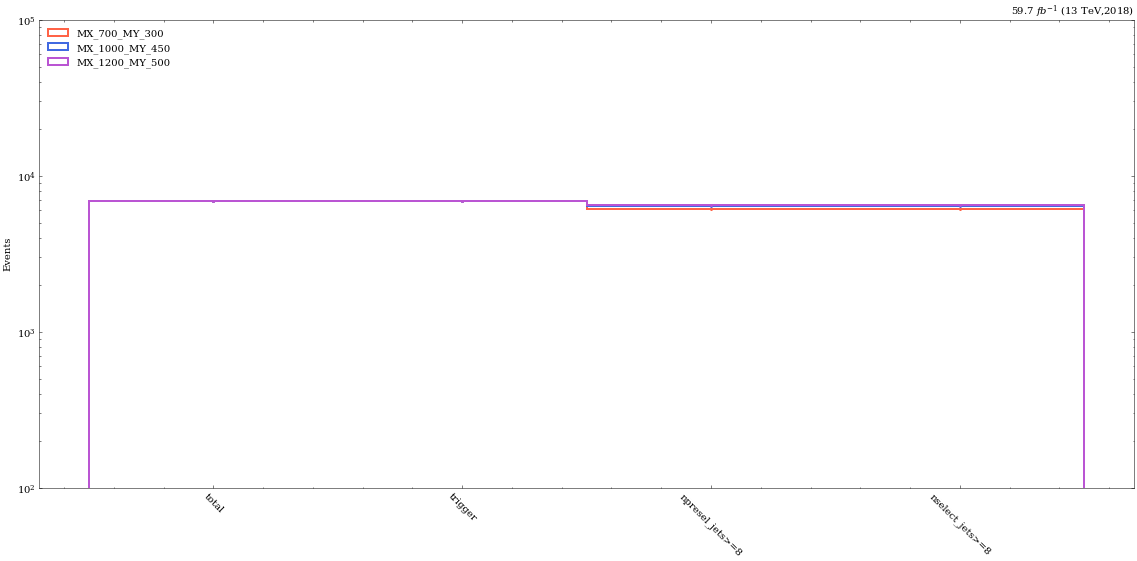

In [5]:
study.cutflow(
    signal_trees,
    legend=True,
    ylim=(1e2,1e5)
)

In [6]:
ylist = [
    f'gen_{y}'
    for y in ('Y1','Y2')
]

higgslist = [
    f'gen_{h}{y}'
    for y in ('Y1','Y2')
    for h in ('H1','H2')
]


quarklist = [
    f'gen_{h}{y}_{b}'
    for y in ('Y1','Y2')
    for h in ('H1','H2')
    for b in ('b1','b2')
]

In [7]:
def make_quark_variables(tree):
    quarks = ak.zip({
        var: ak.concatenate([tree[f'{quark}_{var}'][:, None]
                            for quark in quarklist], axis=-1)
        for var in ('pt', 'eta', 'phi', 'm')
    })
    quark_quark_dr = calc_dr(
        quarks.eta[:, :, None], quarks.phi[:, :, None], quarks.eta[:, None], quarks.phi[:, None])
    quark_min_quark_dr = ak.argmin(quark_quark_dr[quark_quark_dr != 0], axis=-1, keepdims=True)
    quark_min_quark_dr_id = ak.local_index(quark_quark_dr,axis=-1)[quark_quark_dr != 0][quark_min_quark_dr]
    quark_min_quark_dr = quark_quark_dr[quark_min_quark_dr_id][:,:,0]
    quark_min_quark_dr_id = quark_min_quark_dr_id[:,:,0]
    quark_n_quark_dr4 = ak.sum(
        quark_quark_dr[quark_quark_dr != 0] < 0.4, axis=-1)
    genjets = ak.zip({
        var: ak.concatenate(
            [tree[f'{quark}_genjet_{var}'][:, None] for quark in quarklist], axis=-1)
        for var in ('pt', 'eta', 'phi', 'm')
    })
    quark_genjet_dr = calc_dr(
        quarks.eta[:, :, None], quarks.phi[:, :, None], genjets.eta[:, None], genjets.phi[:, None])
    quark_min_genjet_dr = ak.min(quark_genjet_dr, axis=-1)
    quark_n_genjet_dr4 = ak.sum(quark_genjet_dr < 0.4, axis=-1)
    
    quarks_matched = 1*(genjets.pt > 0)
    
    sibMap = {0:1,2:3,4:5,6:7}
    sibMap.update({v:k for k,v in sibMap.items()})
    cos1Map = {0:[2,3],1:[2,3],2:[0,1],3:[0,1],4:[6,7],5:[6,7],6:[4,5],7:[4,5]}
    cos2Map = {0:[4,5,6,7],1:[4,5,6,7],2:[4,5,6,7],3:[4,5,6,7],4:[0,1,2,3],5:[0,1,2,3],6:[0,1,2,3],7:[0,1,2,3]}

    tree.extend(
        **{
            f'gen_{quark}_id': i*ak.ones_like(tree.Run)
            for i, quark in enumerate(eightb.quarklist)
        },
        **{
            f'{quark}_sib_quark_dr': quark_quark_dr[:, i, sibMap[i]]
            for i, quark in enumerate(quarklist)
        },
        **{
            f'{quark}_min_cos1_quark_dr': ak.min(quark_quark_dr[:, i, cos1Map[i]],axis=-1)
            for i, quark in enumerate(quarklist)
        },
        **{
            f'{quark}_min_cos2_quark_dr': ak.min(quark_quark_dr[:, i, cos2Map[i]],axis=-1)
            for i, quark in enumerate(quarklist)
        },
        **{
            f'{quark}_min_quark_dr': quark_min_quark_dr[:, i]
            for i, quark in enumerate(quarklist)
        },
        **{
            f'{quark}_min_quark_dr_id': quark_min_quark_dr_id[:, i]
            for i, quark in enumerate(quarklist)
        },
        **{
            f'{quark}_min_genjet_dr': quark_min_genjet_dr[:, i]
            for i, quark in enumerate(quarklist)
        },
        **{
            f'{quark}_n_genjet_dr4': quark_n_genjet_dr4[:, i]
            for i, quark in enumerate(quarklist)
        },
        **{
            f'{quark}_n_quark_dr4': quark_n_quark_dr4[:, i]
            for i, quark in enumerate(quarklist)
        },
        **{
            f'{quark}_matched': quarks_matched[:, i]
            for i, quark in enumerate(quarklist)
        },
        **{
            f'gen_H1Y1_quark_dr': quark_quark_dr[:, 0, 1],
            f'gen_H2Y1_quark_dr': quark_quark_dr[:, 2, 3],
            f'gen_H1Y2_quark_dr': quark_quark_dr[:, 4, 5],
            f'gen_H2Y2_quark_dr': quark_quark_dr[:, 6, 7],
            f'n_matched_gen_quark':ak.sum(quarks_matched, axis=-1),
            f'n_unmatched_gen_quark':ak.sum(quarks_matched==0,axis=-1),
            f'n_unmatched_gen_quark_dr4h':ak.sum((quarks_matched==0)&(quark_min_genjet_dr>0.4),axis=-1),
            f'n_unmatched_gen_quark_dr4l':ak.sum((quarks_matched==0)&(quark_min_genjet_dr<0.4),axis=-1),
        }
    )


In [8]:
(signal_trees+full_signal_trees).apply(make_quark_variables)
(signal_trees+full_signal_trees).apply(lambda t : build_collection(t,'gen_H\dY\d_b\d','gen_quark', ptordered=True))

[None, None, None, None, None, None, None, None, None, None, None]

100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


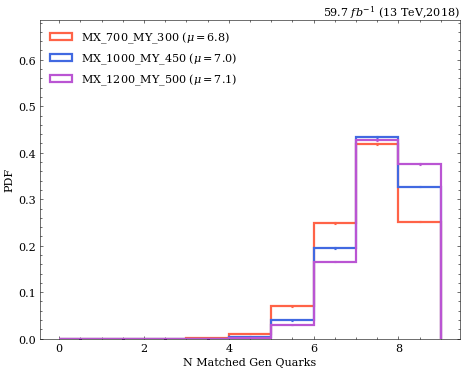

In [9]:
study.quick(
    signal_trees, legend=True,
    h_label_stat='mean',
    varlist=['n_matched_gen_quark'],
    xlabels=['N Matched Gen Quarks'],
    efficiency=True,
    saveas=f'{dout}/n_matched_gen_quark'
)

100%|██████████| 4/4 [00:00<00:00, 16.60it/s]


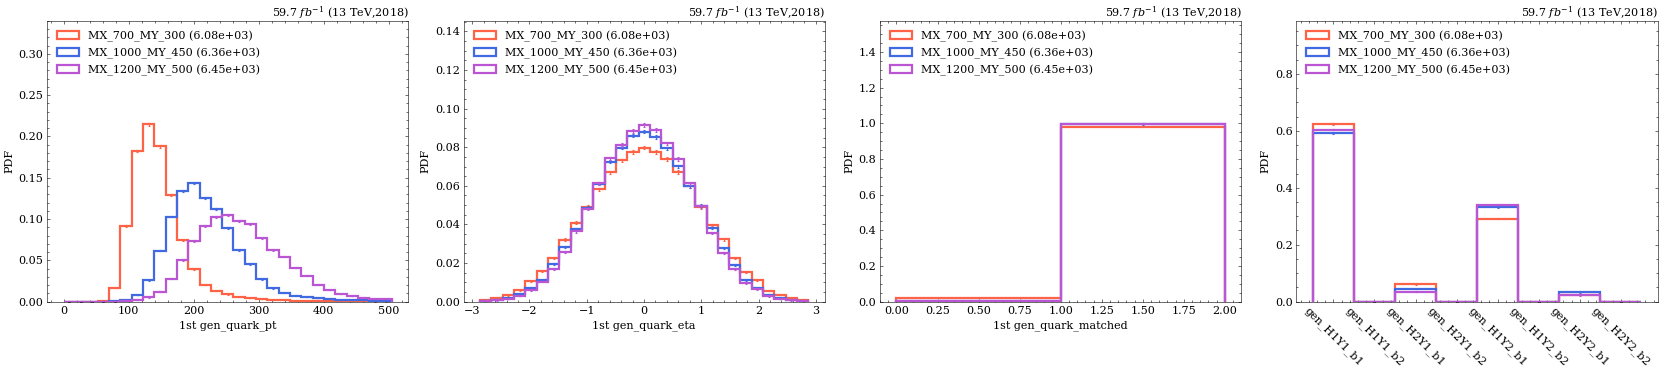

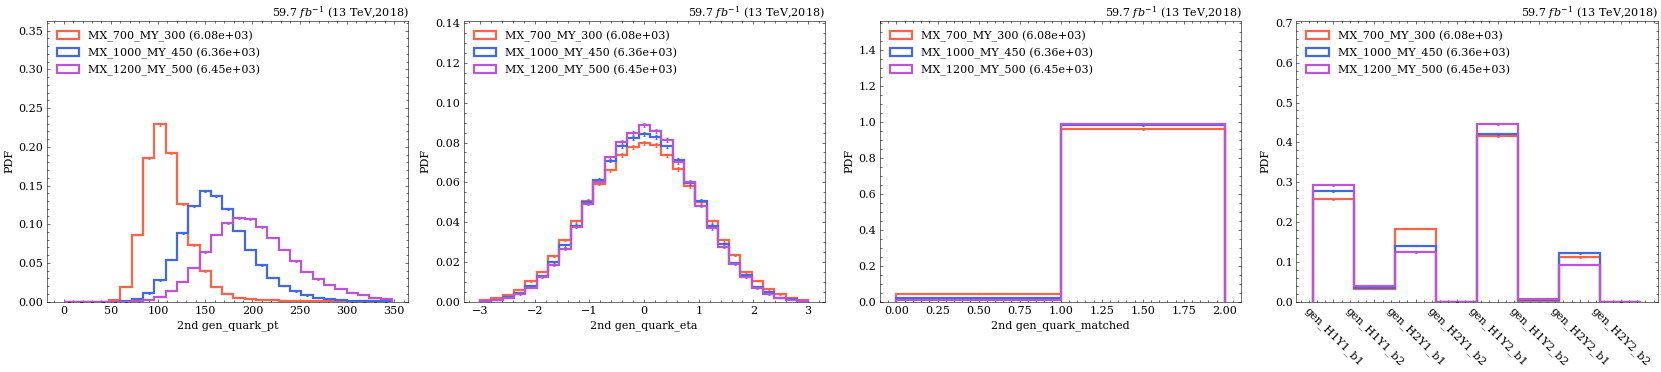

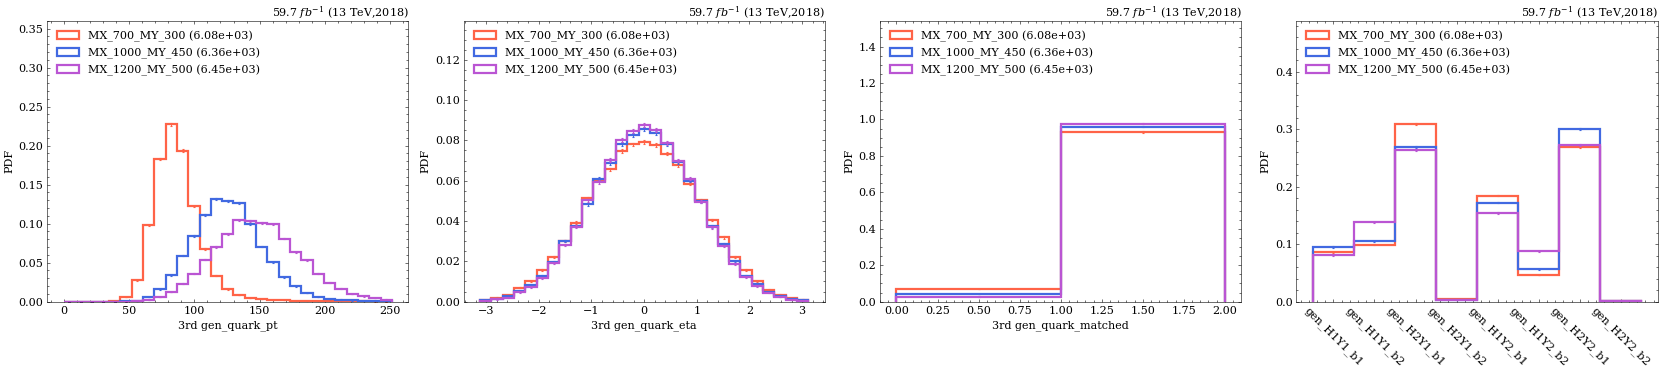

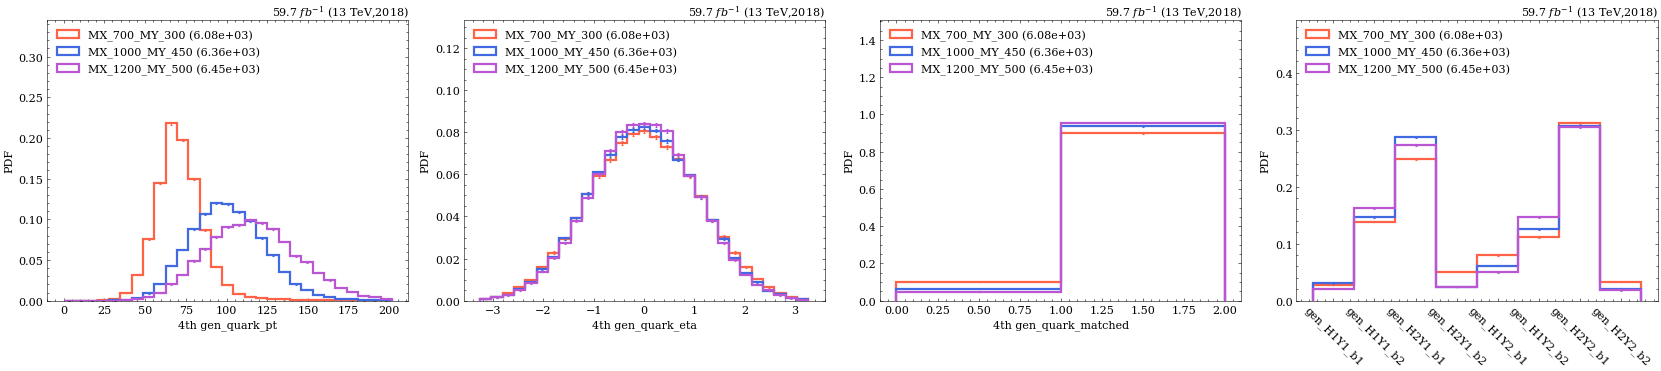

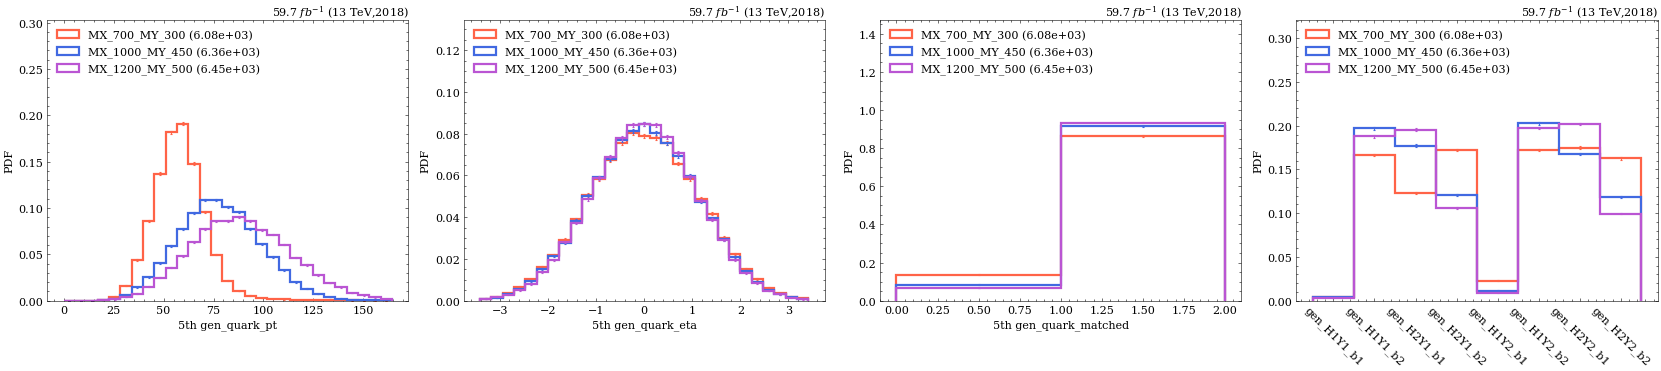

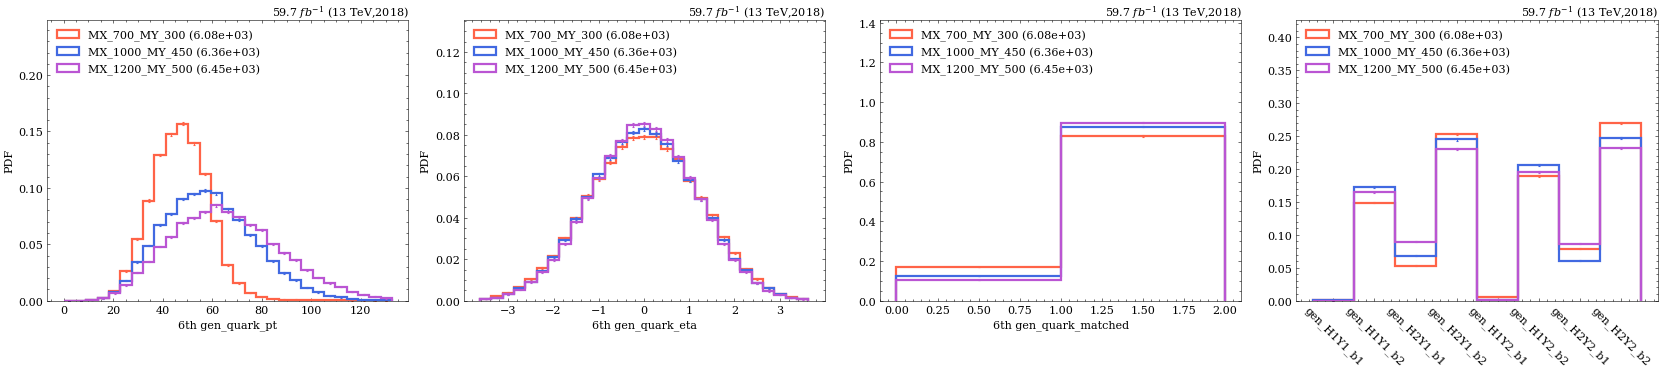

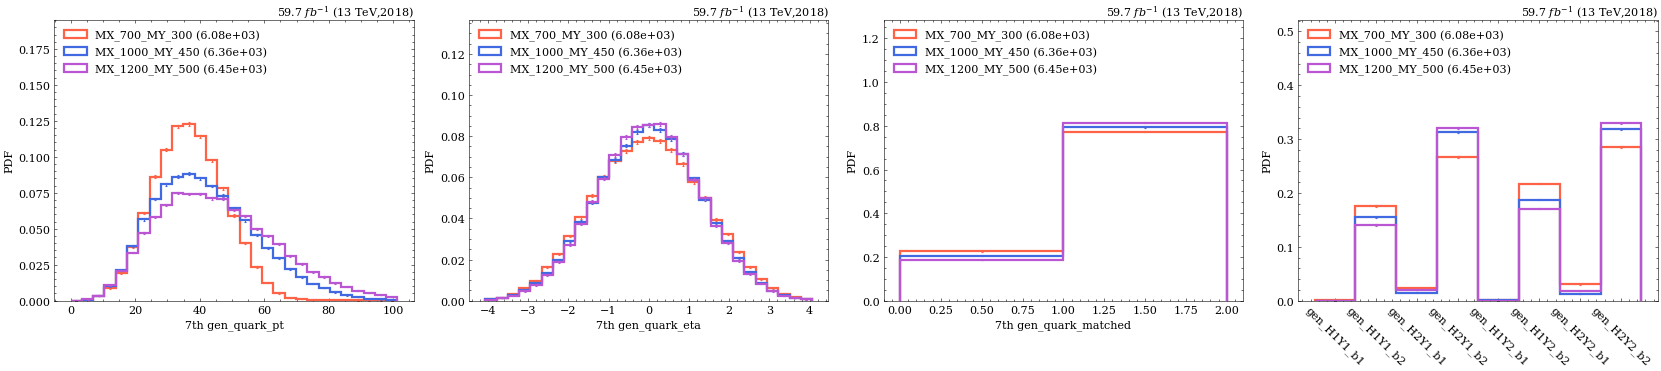

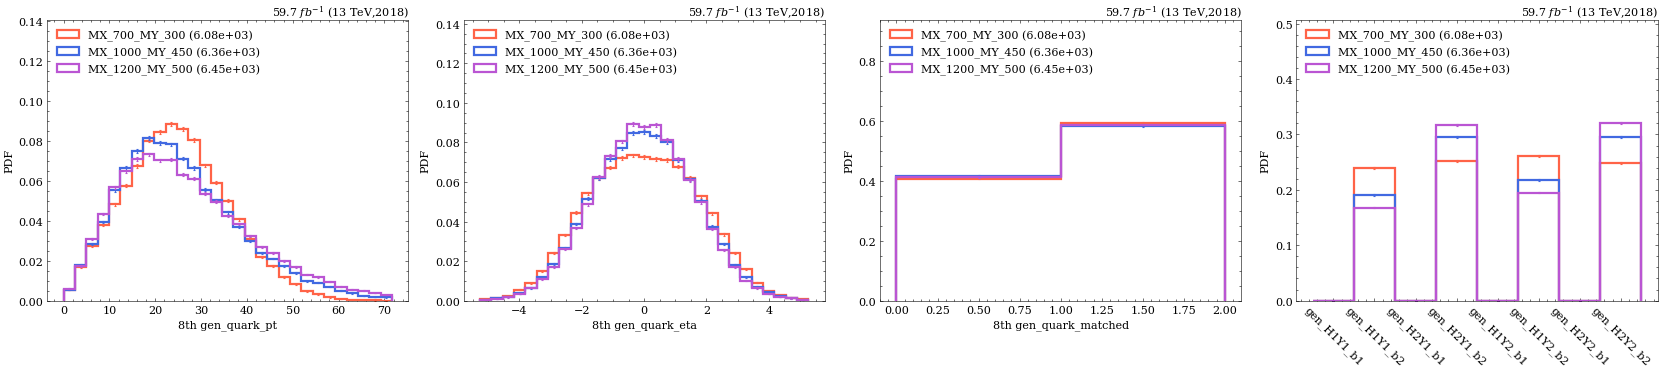

In [10]:
varlist = ['pt','eta','matched','id']

varinfo.gen_quark_id = dict(xlabel=[f"gen_{quark}" for quark in eightb.quarklist], bins=np.arange(9))

for i,quark in enumerate(quarklist):
    ptinfo = signal_trees[f'gen_quark_pt[:,{i}]'].apply(get_avg_std).npy.max(axis=0)
    ptmax = ptinfo[0] + 3*ptinfo[1]
    study.quick(
        signal_trees, legend=True,
        varlist=[f'gen_quark_{var}[:,{i}]' for var in varlist],
        efficiency=True,
        binlist=[(0,ptmax,30)],
        dim=(-1,len(varlist)),
        saveas=f'{dout}/{ordinal(i)}_pt_gen_quark'
    )

100%|██████████| 4/4 [00:01<00:00,  3.04it/s]


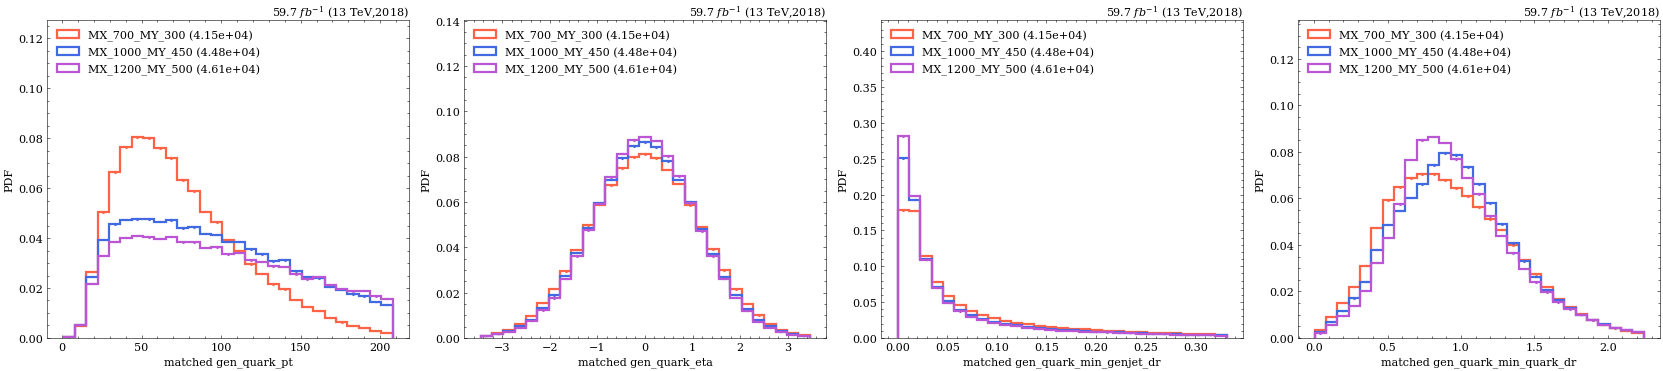

In [11]:
varlist=['pt','eta','min_genjet_dr','min_quark_dr']
study.quick(
    signal_trees, legend=True, 
    indices=lambda t:t.gen_quark_matched==1,
    varlist=[f'gen_quark_{var}' for var in varlist],
    xlabels=[f'matched gen_quark_{var}' for var in varlist],
    dim=-1,
    efficiency=True,
    saveas=f'{dout}/matched_quark'
)

100%|██████████| 4/4 [00:00<00:00,  9.54it/s]


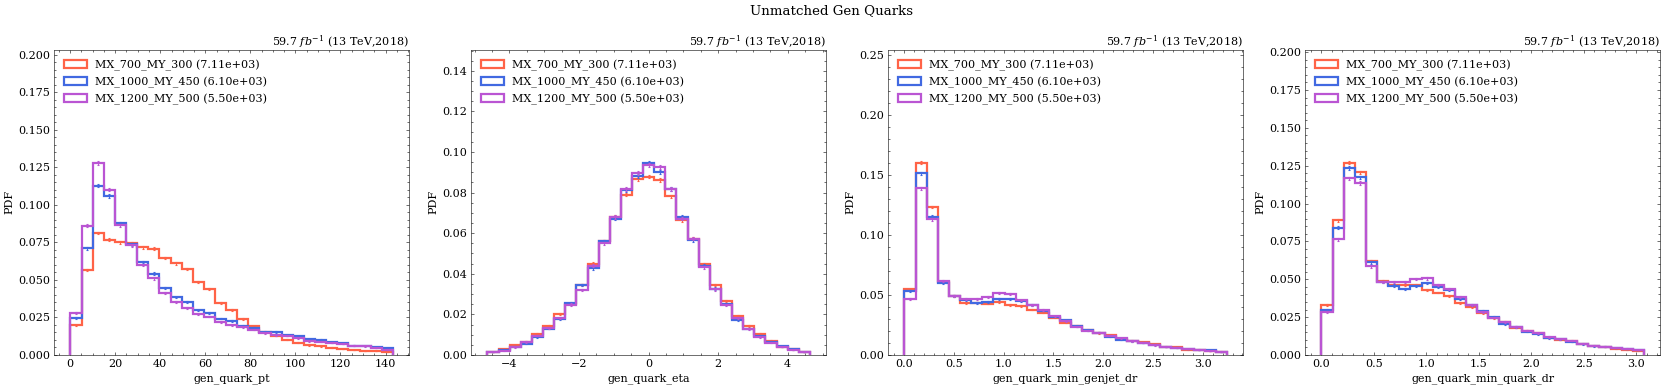

In [12]:
varlist=['pt','eta','min_genjet_dr','min_quark_dr']
study.quick(
    signal_trees, legend=True, 
    indices=lambda t:t.gen_quark_matched==0,
    suptitle='Unmatched Gen Quarks',
    varlist=[f'gen_quark_{var}' for var in varlist],
    xlabels=[f'gen_quark_{var}' for var in varlist],
    dim=-1,
    efficiency=True,
    saveas=f'{dout}/unmatched_quark'
)

100%|██████████| 2/2 [00:00<00:00, 20.76it/s]


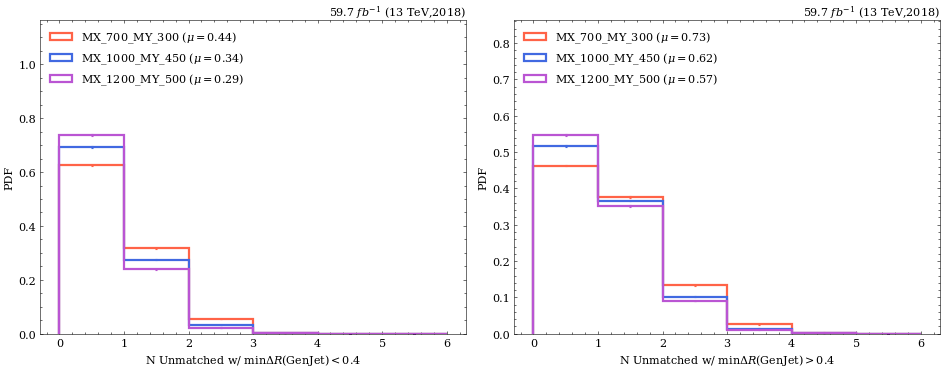

In [13]:
study.quick(
    signal_trees, legend=True, h_label_stat='mean',
    varlist=['n_unmatched_gen_quark_dr4l','n_unmatched_gen_quark_dr4h'],
    xlabels=['N Unmatched w/ $\min \Delta R$(GenJet)$<0.4$','N Unmatched w/ $\min \Delta R$(GenJet)$>0.4$'],
    efficiency=True,
    saveas=f'{dout}/unmatched_quark_multiplicity'
)

In [21]:
def frac_unmatched(t):
    n_unmatched_quarks = ak.sum(t.gen_quark_matched == 0,axis=-1)
    n_unmatched_quarks_dr4l = ak.sum( (t.gen_quark_matched==0)&(t.gen_quark_min_genjet_dr<0.4), axis=-1)
    n_unmatched_quarks_dr4h = ak.sum( (t.gen_quark_matched==0)&(t.gen_quark_min_genjet_dr>0.4), axis=-1)

    frac_unmatched = ak.mean(n_unmatched_quarks>0)
    frac_unmatched_dr4l = ak.mean(n_unmatched_quarks_dr4l>0)
    frac_unmatched_dr4h = ak.mean(n_unmatched_quarks_dr4h>0)

    print(
        f"{t.sample}:\n"
        f"\tFraction Events with Unmatched:        {frac_unmatched:0.2f}\n"
        f"\tFraction Events with Unmatched dR<0.4: {frac_unmatched_dr4l:0.2f}\n"
        f"\tFraction Events with Unmatched dR>0.4: {frac_unmatched_dr4h:0.2f}\n"
    )
    # return frac_unmatched, frac_unmatched_dr4l, frac_unmatched_dr4h

full_signal_trees.apply(frac_unmatched);

MX_700_MY_300:
	Fraction Events with Unmatched:        0.75
	Fraction Events with Unmatched dR<0.4: 0.38
	Fraction Events with Unmatched dR>0.4: 0.54

MX_800_MY_300:
	Fraction Events with Unmatched:        0.73
	Fraction Events with Unmatched dR<0.4: 0.37
	Fraction Events with Unmatched dR>0.4: 0.52

MX_800_MY_350:
	Fraction Events with Unmatched:        0.72
	Fraction Events with Unmatched dR<0.4: 0.34
	Fraction Events with Unmatched dR>0.4: 0.52

MX_900_MY_300:
	Fraction Events with Unmatched:        0.73
	Fraction Events with Unmatched dR<0.4: 0.38
	Fraction Events with Unmatched dR>0.4: 0.50

MX_900_MY_400:
	Fraction Events with Unmatched:        0.70
	Fraction Events with Unmatched dR<0.4: 0.32
	Fraction Events with Unmatched dR>0.4: 0.50

MX_1000_MY_300:
	Fraction Events with Unmatched:        0.73
	Fraction Events with Unmatched dR<0.4: 0.42
	Fraction Events with Unmatched dR>0.4: 0.48

MX_1000_MY_450:
	Fraction Events with Unmatched:        0.67
	Fraction Events with Unmatched 

100%|██████████| 4/4 [00:00<00:00,  6.43it/s]


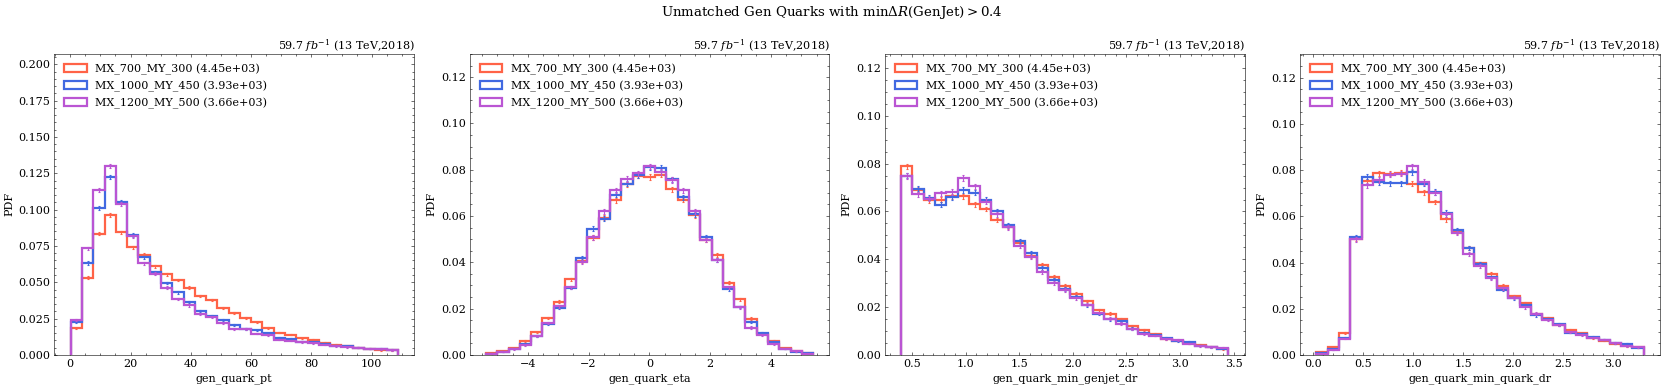

In [15]:
varlist=['pt','eta','min_genjet_dr','min_quark_dr']
study.quick(
    signal_trees, legend=True, 
    indices=lambda t:(t.gen_quark_matched==0)&(t.gen_quark_min_genjet_dr>0.4),
    suptitle='Unmatched Gen Quarks with $\min\Delta R($GenJet$)>0.4$',
    varlist=[f'gen_quark_{var}' for var in varlist],
    dim=-1,
    efficiency=True,
    saveas=f'{dout}/unmatched_quark_dr4h'
)

100%|██████████| 4/4 [00:00<00:00,  6.85it/s]


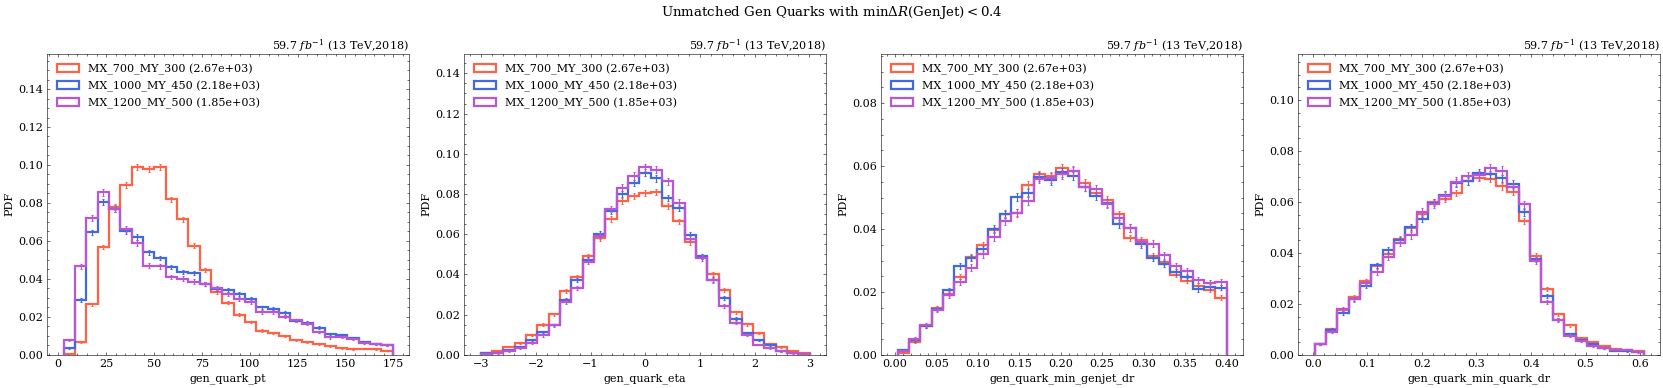

In [16]:
varlist=['pt','eta','min_genjet_dr','min_quark_dr']
study.quick(
    signal_trees, legend=True, 
    indices=lambda t:(t.gen_quark_matched==0)&(t.gen_quark_min_genjet_dr<0.4),
    suptitle='Unmatched Gen Quarks with $\min\Delta R($GenJet$)<0.4$',
    varlist=[f'gen_quark_{var}' for var in varlist],
    dim=-1,
    efficiency=True,
    saveas=f'{dout}/unmatched_quark_dr4l'
)

In [241]:
t = signal_trees[0]

quark = t.gen_quark_id
min_quark = t.gen_quark_min_quark_dr_id

In [248]:
hid = ((quark)//2) == ((min_quark)//2)
yid = ((quark)//4) == ((min_quark)//4)
xid = ((quark)//8) == ((min_quark)//8)

<Array [[0, 2, 1], [0, 2, ... 0, 1], [0, 0, 1]] type='8 * var * ?int64'>

In [17]:
def min_quark_relation(t):
    quark = t.gen_quark_id
    min_quark = t.gen_quark_min_quark_dr_id

    hid = ((quark)//2) == ((min_quark)//2)
    yid = ((quark)//4) == ((min_quark)//4)
    xid = ((quark)//8) == ((min_quark)//8)

    relation = ak_stack([3*hid, 2*yid, 1*xid])
    relation = 3 - ak.max(relation, axis=1)

    t.extend(
        gen_quark_min_quark_dr_relation=relation
    )

(signal_trees+full_signal_trees).apply(min_quark_relation)

[None, None, None, None, None, None, None, None, None, None, None]

In [18]:
indices = lambda t:(t.gen_quark_matched==0)&(t.gen_quark_min_genjet_dr<0.4)
def family_fraction(t):
    relation = t.gen_quark_min_quark_dr_relation
    mask = indices(t)
    relation = relation[mask]

    n_sibs = ak.sum(relation == 0, axis=-1)
    n_cos1 = ak.sum(relation == 1, axis=-1)
    n_cos2 = ak.sum(relation == 2, axis=-1)

    frac_sibs = ak.mean(n_sibs>0)
    frac_cos1 = ak.mean(n_cos1>0)
    frac_cos2 = ak.mean(n_cos2>0)

    print(
        f"{t.sample}:\n"
        f"\tFraction Events with Unmatched Overlapping Sibs: {frac_sibs:0.3%}\n"
        f"\tFraction Events with Unmatched Overlapping Cos1: {frac_cos1:0.3%}\n"
        f"\tFraction Events with Unmatched Overlapping Cos2: {frac_cos2:0.3%}\n"
    )
    

full_signal_trees.apply(family_fraction)

MX_700_MY_300:
	Fraction Events with Unmatched Overlapping Sibs: 0.005%
	Fraction Events with Unmatched Overlapping Cos1: 16.774%
	Fraction Events with Unmatched Overlapping Cos2: 23.932%

MX_800_MY_300:
	Fraction Events with Unmatched Overlapping Sibs: 0.029%
	Fraction Events with Unmatched Overlapping Cos1: 22.965%
	Fraction Events with Unmatched Overlapping Cos2: 17.215%

MX_800_MY_350:
	Fraction Events with Unmatched Overlapping Sibs: 0.038%
	Fraction Events with Unmatched Overlapping Cos1: 10.716%
	Fraction Events with Unmatched Overlapping Cos2: 24.906%

MX_900_MY_300:
	Fraction Events with Unmatched Overlapping Sibs: 0.068%
	Fraction Events with Unmatched Overlapping Cos1: 29.056%
	Fraction Events with Unmatched Overlapping Cos2: 12.272%

MX_900_MY_400:
	Fraction Events with Unmatched Overlapping Sibs: 0.074%
	Fraction Events with Unmatched Overlapping Cos1: 7.518%
	Fraction Events with Unmatched Overlapping Cos2: 26.092%

MX_1000_MY_300:
	Fraction Events with Unmatched Overlapp

[None, None, None, None, None, None, None, None]

100%|██████████| 1/1 [00:00<00:00,  7.48it/s]


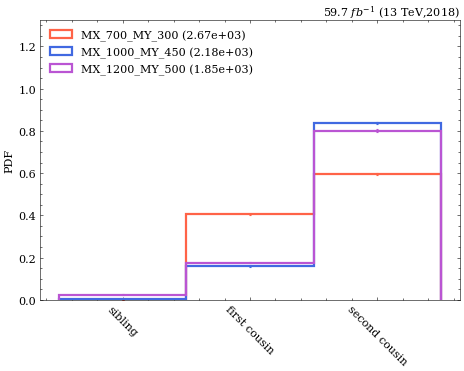

In [19]:
varinfo.gen_quark_min_quark_dr_relation = dict(xlabel=['sibling','first cousin','second cousin'])
study.quick(
    signal_trees, legend=True, 
    indices=lambda t:(t.gen_quark_matched==0)&(t.gen_quark_min_genjet_dr<0.4),
    varlist=[f'gen_quark_min_quark_dr_relation'],
    dim=-1,
    efficiency=True,
    saveas=f'{dout}/unmatched_quark_family_dr'
)

100%|██████████| 3/3 [00:00<00:00,  6.91it/s]


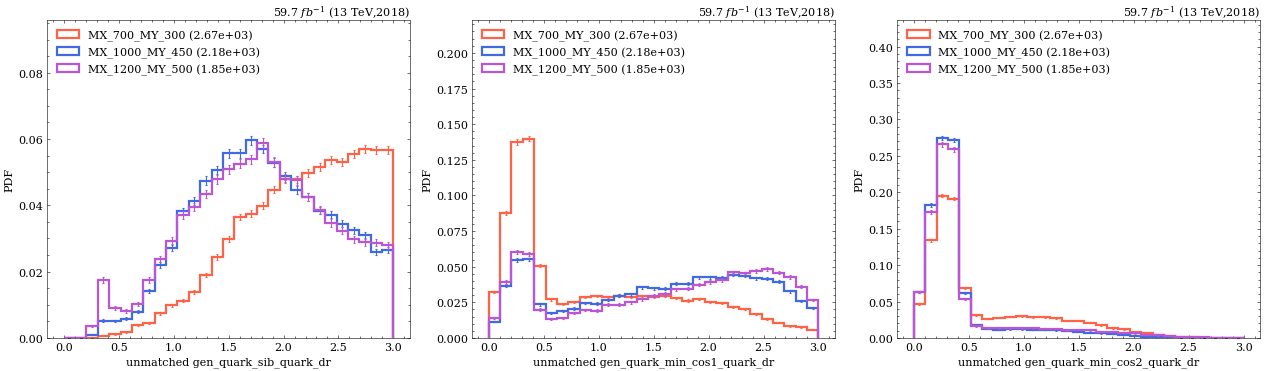

In [20]:
varlist=['sib_quark_dr','min_cos1_quark_dr','min_cos2_quark_dr']
study.quick(
    signal_trees, legend=True, 
    indices=lambda t:(t.gen_quark_matched==0)&(t.gen_quark_min_genjet_dr<0.4),
    varlist=[f'gen_quark_{var}' for var in varlist],
    xlabels=[f'unmatched gen_quark_{var}' for var in varlist],
    binlist=[(0,3,30)]*3,
    dim=-1,
    efficiency=True,
    saveas=f'{dout}/unmatched_quark_family_dr'
)